# installing library and prepare some classes

In [ ]:
!nvidia-smi

Sun Jun  4 14:50:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00


In [ ]:
pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=de5e7dcc6fae4069a91f58c472fac7227ce44e23a3bd18ad9fb243a59037b391
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 18.6 MB/s eta 0:00:00


In [ ]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Dense
from transformers import AutoTokenizer, TFAutoModel, TFRobertaModel, TFBertModel, pipeline
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

import nltk
nltk.download('punkt')
from stop_words import get_stop_words
stop_words = get_stop_words('en')
import contractions
# for remove accented char (normalize words)
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel(logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class importData():
  def __init__(self, fileName):
    self.df = pd.read_csv(fileName, sep=",", header=0, encoding="utf-8")
  
  def remove_stopword(self, text):
    wordList = []
    tempText = nltk.word_tokenize(text)
    for word in tempText:
      if word not in stop_words:
        wordList.append(word)
    text = (" ".join(wordList))
    return text

  def expand_contractions(self, text):
    return contractions.fix(text)
  
  def remove_html(self, text):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(CLEANR, '', text)

  def remove_email(self, text):
    return re.sub(r'\S*@\S*\s?', "", text)

  # change chinese char, accented char into alphabetical words
  def normalize_characters(self, text):
    return unidecode(text)

  def remove_special(self, text):
    return re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]"," ", text)
  
  def remove_number(self, text):
    return re.sub("\d+", "",text)

  #text processing for column name is defined by user as string
  def text_preprocessing(self, column):
    tqdm.pandas()
    self.df[column] = self.df[column].progress_apply(lambda x: self.normalize_characters(str(x)))
    self.df[column] = self.df[column].progress_apply(lambda x: self.remove_email(str(x)))
    self.df[column] = self.df[column].progress_apply(lambda x: self.remove_html(str(x)))
    self.df[column] = self.df[column].progress_apply(lambda x: self.remove_special(str(x)))
    self.df[column] = self.df[column].progress_apply(lambda x: self.expand_contractions(str(x))) #you're -> you are; i'm -> i am
    self.df[column] = self.df[column].progress_apply(lambda x: self.remove_number(str(x)))
    self.df[column] = self.df[column].progress_apply(lambda x: str(x).lower())
    # self.df[column] = self.df[column].progress_apply(lambda x: self.remove_stopword(str(x)))


  def splitTrain(self, test_size, text, label):
    data = self.df[text]
    label = self.df[label]
    self.Train_X, self.Test_X, self.Train_Y, self.Test_Y = train_test_split(data, 
                                                                            label, 
                                                                            test_size=test_size, 
                                                                            random_state=0, 
                                                                            stratify=label)
    
    self.Train_X, self.Val_X, self.Train_Y, self.Val_Y = train_test_split(self.Train_X, 
                                                                            self.Train_Y, 
                                                                            test_size=0.1, 
                                                                            random_state=0, 
                                                                            stratify=self.Train_Y)
    
    return self.Train_X, self.Val_X, self.Test_X, self.Train_Y, self.Val_Y, self.Test_Y

  def getData(self):
    return self.df
    
  def maxLenText(self, text):
    listLenTest = self.df[text].apply(lambda x:len(x.split()))
    return max(listLenTest)

  def convertLabel(self, labelColumn, dictLabelNumber):
    self.df[labelColumn] = self.df[labelColumn].map(dictLabelNumber)

In [ ]:
#create class customBert as a modification of Bert
class customBert():
  #constructor function using bert tokenizer and bert model
  def __init__(self, tokenizer, bertModel):
    self.tokenizer = tokenizer
    self.bertModel = bertModel

  #function for tokenizing with data is a dataframe (train/test data)
  #maxlen is maximum length of text for tokenizing
  #text is the column name for text that will be processed
  def tokenizeProcess(self, data, maxlen=256, text=""):
    x_tok= self.tokenizer(
        text=data[text].tolist(),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding="max_length", 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    return x_tok

  #creating a model with several layer with number of label/class/cluster with maximum length of sentence
  def create_model(self, numberCluster, max_len):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    #create embedding from bert model
    embeddings = self.bertModel(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = Dense(128, activation='relu', name='dense1')(out)
    out = tf.keras.layers.Dropout(0.1, name='dropout1')(out)
    out = Dense(32,activation = 'relu', name='dense2')(out)

    y = Dense(numberCluster,activation = 'softmax', name='dense3')(out)
        
    self.model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    return self.model
  
  #function for fine tune twice with new dataset based on previous model that has been trained with other dataset
  #numberCluster is a new number of cluster in a new dataset, with maxlen is the maximum length of a sentence
  def fineTune(self, numberCluster, max_len):
    
    for layer in self.model.layers:
      layer.trainable = True
    #set output of the previous model in one layer before classifier layer as an input for new layer
    #ignore the classifier layer from previous model (-1 is a classifier/output layer)
    #-2 means one layer before classifier layer
    #add some layers
    out = self.model.layers[-2].output
    out = Dense(128, activation='relu', name='dense4')(out)
    out = tf.keras.layers.Dropout(0.1, name='dropout2')(out)
    out = Dense(32,activation = 'relu', name='dense5')(out)
    y = Dense(numberCluster,activation = 'softmax')(out)
        
    self.model = tf.keras.Model(inputs=self.model.input, outputs=y)
    return self.model

  #compiling a model with specific learning rate
  #static loss function and metric
  def modelCompile(self, learningRate):
    optimizer = Adam(learning_rate=learningRate, 
                    epsilon=1e-08,
                    #decay=0.01,
                    clipnorm=1.0)

    # Set loss and metrics
    loss =  CategoricalCrossentropy()
    metric = CategoricalAccuracy('accuracy')
    self.model.compile(optimizer = optimizer,
                      loss = loss, 
                      metrics = metric)

  #fit the model with data result from bert tokenizer train, test with ids and attention mask
  #train_Y is label from training data
  #test_Y is label from test data
  def fitModel(self, x_train, x_test, Train_Y, Test_Y, epochs, batchSize):
    history = self.model.fit(x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
              y = to_categorical(Train_Y),
              validation_data = (
              {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(Test_Y)
              ),
            epochs=epochs,
              batch_size=batchSize
          )
    return history

  #save model in the form of h5 filetype in folderName
  def saveModel(self, folderName):
    self.model.save(folderName+'model.h5')

  #load model from folderName with h5 filetype TFAutoModel as model as it is used in bert model in this class
  def load_model_roberta(self, folderName):
    self.model = load_model(folderName+'model.h5', custom_objects={'TFRobertaModel':TFRobertaModel}, compile=True, options=None)

  #load model from folderName with h5 filetype TFBertModel as model as it is used in bert model in this class
  def load_model_bert(self, folderName):
    self.model = load_model(folderName+'model.h5', custom_objects={'TFBertModel':TFBertModel}, compile=True, options=None)

  #prediction function to predict test data into a label
  def pred(self, x_test):
    predicted_raw = self.model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
    result = np.argmax(predicted_raw, axis = 1)
    return result

  #prediction function to predict test data into a label
  def pred_single_text(self, max_len=256, testText=""):
    data_test = {"Text":[testText]}
    df_dataTest = pd.DataFrame(data_test)
    result = self.pred(self.tokenizeProcess(df_dataTest, max_len, 'Text'))
    return result

  #get the model that might be use to display a model summary
  def getModel(self):
    return self.model

In [ ]:
class report():
  def __init__(self, modelObj, x_test, Test_Y):
    self.modelObj = modelObj
    self.Test_X = x_test
    self.Test_Y = Test_Y

  #display confusion matrix 
  def displayConfusion(self):
    plt.figure(figsize=(10,7))
    prediction = self.modelObj.pred(self.Test_X)
    print ("\nHere is the classification report:") 
    print (classification_report(list(self.Test_Y), prediction))
    sns.heatmap(confusion_matrix(list(self.Test_Y),prediction),annot=True,cmap='viridis')
    plt.show()

  def plotLoss(self, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'r-', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
class summary():
  def __init__(self, modelObj="facebook/bart-large-cnn"):
    self.modelObj = modelObj

  # summary a text at minimum 30 words, and max is 130 words
  def summary_result(self, text):
    summarizer = pipeline("summarization", model=self.modelObj)
    return summarizer(text, max_length=130, min_length=30, do_sample=False)[0]['summary_text']


# Create model only for scraped news dataset

## Load scraped news dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

Saving politic_society_business.csv to politic_society_business.csv


## Cleaning text content

In [ ]:
data = importData(file_name)

In [ ]:
data.getData()

,Url,Title,Text,Date,Views,Label
0,https://www.taiwannews.com.tw/en/news/4796805,Taiwan Legislative Speaker You Si-kun arrives ...,"TAIPEI (Taiwan News) — After a 14-hour flight,...",2023/2/1,688.0,Politics
1,https://www.taiwannews.com.tw/en/news/4797037,Taiwan tops Asia in 2022 Human Freedom Index,TAIPEI (Taiwan News) — Taiwan emerged as the f...,2023/2/1,1081.0,Society
2,https://www.taiwannews.com.tw/en/news/4797083,Duck hunt comes to conclusion in southern Taiwan,TAIPEI (Taiwan News) — One would be tempted to...,2023/2/1,2304.0,Society
3,https://www.taiwannews.com.tw/en/news/4797107,Taiwan business leader joins DPP-linked think ...,TAIPEI (Taiwan News) — The chairman of Pegatro...,2023/2/1,622.0,Politics
4,https://www.taiwannews.com.tw/en/news/4797204,DPP Chairman Lai names 3 key tasks for Taiwan’...,TAIPEI (Taiwan News) — In his first address to...,2023/2/1,879.0,Politics
...,...,...,...,...,...,...
822,https://www.taiwannews.com.tw/en/news/4841075,"If China attacks Taiwan, war could start in sp...",TAIPEI (Taiwan News) — In a new CBS broadcast ...,2023/3/20,8922.0,Politics
823,https://www.taiwannews.com.tw/en/news/4841082,"Taiwan, Japan ruling parties to discuss securi...",TAIPEI (Taiwan News) — Taiwan’s Democratic Pro...,2023/3/20,1134.0,Politics
824,https://www.taiwannews.com.tw/en/news/4841167,"Taiwan TikToker rushes court at Dwight Howard,...",TAIPEI (Taiwan News) — A Taiwanese TikToker ru...,2023/3/20,2857.0,Society
825,https://www.taiwannews.com.tw/en/news/4841191,Putin to host ally Xi in Russia as Ukraine war...,Russian President Vladimir Putin hosts Chinese...,2023/3/20,334.0,Politics


In [ ]:
data.text_preprocessing('Text')

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

In [ ]:
new_df = data.getData()
new_df.value_counts("Label")

Label
Politics    438
Society     261
Business    128
dtype: int64

In [ ]:
data.getData().shape

(827, 6)

In [ ]:
dictLabel = {"Politics": 0, "Society": 1, "Business": 2}
data.convertLabel('Label', dictLabel)
Train_X, Val_X, Test_X, Train_Y, Val_Y, Test_Y = data.splitTrain(0.2, 'Text', 'Label')
train_ds = pd.concat([Train_X, Train_Y], axis=1)
val_ds = pd.concat([Val_X, Val_Y], axis=1)
test_ds = pd.concat([Test_X, Test_Y], axis=1)

## ROBERTA pre-trained model for news classification (scraped dataset)

###load roberta base tokenizer and model to create new pre trained model

In [ ]:
# model_name = 'bert-base-uncased'
model_name = 'roberta-base'
tokenizerBert = AutoTokenizer.from_pretrained(model_name)
modelBert = TFAutoModel.from_pretrained(model_name)
resultBert = customBert(tokenizerBert, modelBert)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


### define maximum length of token that will be process in one data. this number will affect processing time. in tokenizeProcess we need to input column name of text that will be processed

In [ ]:
max_len = 256
  
x_train = resultBert.tokenizeProcess(train_ds, max_len, 'Text')
x_val = resultBert.tokenizeProcess(val_ds, max_len, 'Text')
x_test = resultBert.tokenizeProcess(test_ds, max_len, 'Text')

### create a model using number of cluster based on label dictionary that is used in cleaning part. then compile the model using specific learning rate value

In [ ]:
resultBert.create_model(3, max_len)
resultBert.modelCompile(5e-05)

### train the model using number of epoch and batch size

In [ ]:
history = resultBert.fitModel(x_train, x_val, Train_Y, Val_Y, 2, 16)

Epoch 1/2
38/38 [==============================] - 60s 913ms/step - loss: 0.7524 - accuracy: 0.6987 - val_loss: 0.4610 - val_accuracy: 0.8507
Epoch 2/2
38/38 [==============================] - 33s 858ms/step - loss: 0.2988 - accuracy: 0.8973 - val_loss: 0.4940 - val_accuracy: 0.7910


### display confusion matrix and plot accuracy and loss for the model

6/6 [==============================] - 7s 453ms/step

Here is the classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        88
           1       0.88      0.88      0.88        52
           2       0.94      0.62      0.74        26

    accuracy                           0.90       166
   macro avg       0.91      0.83      0.86       166
weighted avg       0.90      0.90      0.89       166



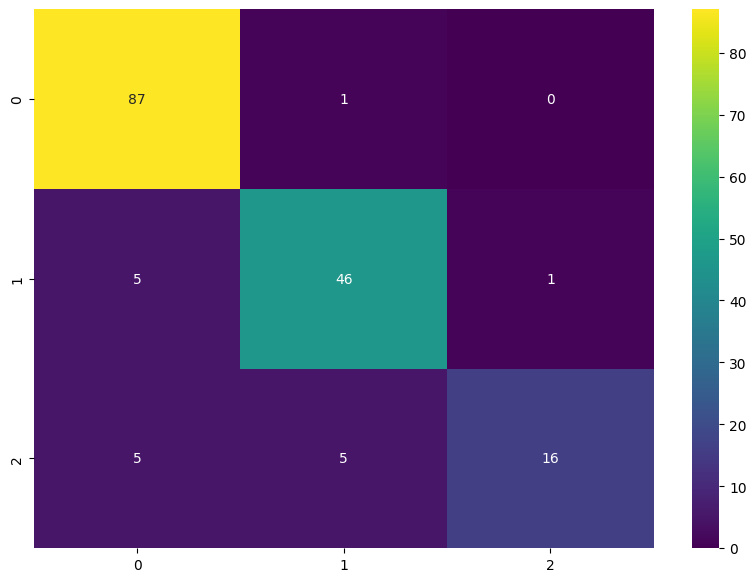

In [ ]:
releaseReport = report(resultBert, x_test, Test_Y)
releaseReport.displayConfusion()

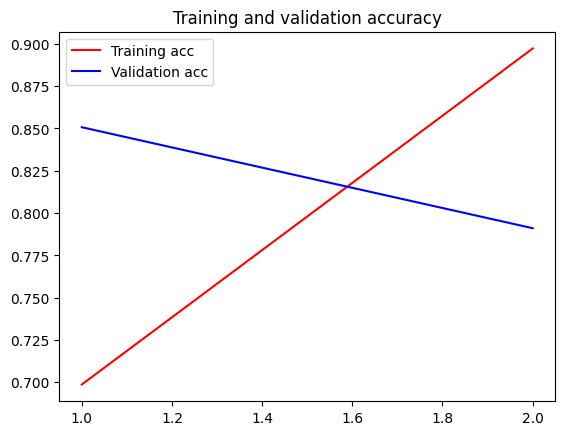

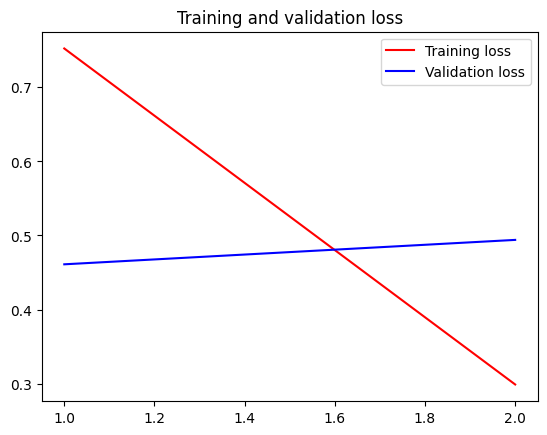

In [ ]:
releaseReport.plotLoss(history)

### save the model to google drive

In [ ]:
resultBert.saveModel('drive/MyDrive/')

### display model summary

In [ ]:
# resultBert.getModel().summary()

### testing the model using input text

In [ ]:
testText = """TAIPEI (Taiwan News) — Taiwan’s gross domestic product (GDP) per capita exceeded South Korea’s in 2022 
for the first time in a decade due to consistent higher average growth, the Ministry of Economic Affairs (MOEA) said Friday (April 28).
The average GDP per person in Taiwan reached US$32,811 (NT$1 million) in Taiwan, while South Korea recorded US$32,237 for last year, 
per CNA. The growth of the semiconductor industry and the return of Taiwanese investors from overseas helped Taiwan achieve an 
average yearly GDP growth of 3.2% over the past decade, while South Korea suffered under a declining currency to book only 2.6% growth per year.
The size of Taiwan’s manufacturing sector grew by a yearly average of 5.5% from 2013 to 2021, while in South Korea, manufacturing only 
expanded by an average of 2.8% per year during the same period. Exports also revealed a different pace of growth for the two countries, 
with an average annual growth rate of 4.6% for Taiwan and of 2.2% for South Korea, with the global average standing at 3%, according to MOEA data.
The gap in exports between the two has been narrowing over the past 10 years, as South Korea exported 1.8 times more than Taiwan in 2013, 
but 1.4 times more in 2021, the Economic Daily News reported."""

In [ ]:
tokenize_result = resultBert.pred_single_text(max_len, testText)

(list(dictLabel.keys())[list(dictLabel.values()).index(tokenize_result[0])])

1/1 [==============================] - 0s 76ms/step


'Business'

### testing the summarization

In [ ]:
summarization = summary()
summary_result = summarization.summary_result(testText)

In [ ]:
summary_result

'The average GDP per person in Taiwan reached US$32,811 (NT$1 million) in Taiwan, while South Korea recorded US $32,237 for last year. The growth of the semiconductor industry helped Taiwan achieve an average yearly GDP growth of 3.2% over the past decade. South Korea suffered under a declining currency to book only 2.6% growth per year.'

# Create model for CNN news dataset

## Load kaggle news dataset. copy cnn dataset to google drive and access by the location

In [ ]:
data_folder = "drive/MyDrive/Colab Notebooks/newsDataset/"
file_name = data_folder + "cnn_news.csv"

## Cleaning text content

In [ ]:
data = importData(file_name)

In [ ]:
data.getData()

,Unnamed: 0,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...
...,...,...,...,...,...,...,...,...,...,...,...,...
37899,37938,44992,"Ben Church and Aleks Klosok, CNN",2022-03-01 10:59:10,sport,sport,https://www.cnn.com/2022/03/01/sport/vladimir-...,Russian President Vladimir Putin is being stri...,Russian President Vladimir Putin has been stri...,"sport, Russian President Vladimir Putin is bei...",Vladimir Putin is being stripped of his honora...,(CNN)Russian President Vladimir Putin has bee...
37900,37939,44993,"Tamara Qiblawi, CNN",2022-03-01 12:55:37,news,europe,https://www.cnn.com/2022/03/01/europe/nato-ukr...,"On NATO's doorstep, a former tourist hotspot i...",A long line of men snakes out of an unassuming...,"europe, On NATO's doorstep, a former tourist h...","On NATO's doorstep, a former tourist hotspot i...","Lviv, Ukraine (CNN)A long line of men snakes o..."
37901,37940,44994,"Wayne Sterling and Steve Almasy, CNN",2022-03-01 11:54:44,sport,sport,https://www.cnn.com/2022/03/01/sport/mlb-deadl...,MLB is postponing Opening Day after owners and...,Major League Baseball (MLB) is postponing its ...,"sport, MLB is postponing Opening Day after own...",MLB is postponing Opening Day after owners and...,(CNN)Major League Baseball (MLB) is postponin...
37902,37941,44996,CNN Editorial Research,2013-01-12 01:42:49,news,europe,https://www.cnn.com/2013/01/11/world/europe/mi...,Mikhail Gorbachev Fast Facts - CNN,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...","europe, Mikhail Gorbachev Fast Facts - CNN",Mikhail Gorbachev Fast Facts,Here's a look at the life of Mikhail Gorbachev...


In [ ]:
data.text_preprocessing('Article text')

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

  0%|          | 0/37904 [00:00<?, ?it/s]

In [ ]:
new_df = data.getData()
new_df.value_counts("Category")

Category
news             18077
sport            15542
politics          2461
business           854
health             557
entertainment      413
dtype: int64

In [ ]:
data.getData().shape

(37904, 12)

In [ ]:
dictLabel = {"news": 0, "sport": 1, "politics": 2, "business": 3, "health": 4,
             "entertainment": 5}
data.convertLabel('Category', dictLabel)
Train_X, Val_X, Test_X, Train_Y, Val_Y, Test_Y = data.splitTrain(0.2, 'Article text', 'Category')
train_ds = pd.concat([Train_X, Train_Y], axis=1)
val_ds = pd.concat([Val_X, Val_Y], axis=1)
test_ds = pd.concat([Test_X, Test_Y], axis=1)

## BERT pre-trained model for news classification (scraped dataset)

### load roberta base tokenizer and model to create new pre trained model

In [ ]:
# model_name = 'bert-base-uncased'
model_name = 'roberta-base'

tokenizerBert = AutoTokenizer.from_pretrained(model_name)
modelBert = TFAutoModel.from_pretrained(model_name)
resultBert = customBert(tokenizerBert, modelBert)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


### define maximum length of token that will be process in one data. this number will affect processing time. in tokenizeProcess we need to input column name of text that will be processed

In [ ]:
max_len = 256
  
x_train = resultBert.tokenizeProcess(train_ds, max_len, 'Article text')
x_val = resultBert.tokenizeProcess(val_ds, max_len, 'Article text')
x_test = resultBert.tokenizeProcess(test_ds, max_len, 'Article text')

### create a model using number of cluster based on label dictionary that is used in cleaning part. then compile the model using specific learning rate value

In [ ]:
resultBert.create_model(6, max_len)
resultBert.modelCompile(5e-05)

### train the model using number of epoch and batch size

In [ ]:
history = resultBert.fitModel(x_train, x_val, Train_Y, Val_Y, 2, 16)

Epoch 1/2
1706/1706 [==============================] - 1639s 947ms/step - loss: 0.2580 - accuracy: 0.9247 - val_loss: 0.3643 - val_accuracy: 0.9314
Epoch 2/2
1706/1706 [==============================] - 1617s 948ms/step - loss: 0.1636 - accuracy: 0.9526 - val_loss: 0.3019 - val_accuracy: 0.9542


### display confusion matrix and plot accuracy and loss for the model

237/237 [==============================] - 139s 571ms/step

Here is the classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3616
           1       0.96      0.99      0.98      3108
           2       0.85      0.91      0.88       492
           3       0.85      0.90      0.87       171
           4       0.82      0.54      0.65       111
           5       0.62      0.84      0.72        83

    accuracy                           0.95      7581
   macro avg       0.85      0.85      0.84      7581
weighted avg       0.95      0.95      0.95      7581



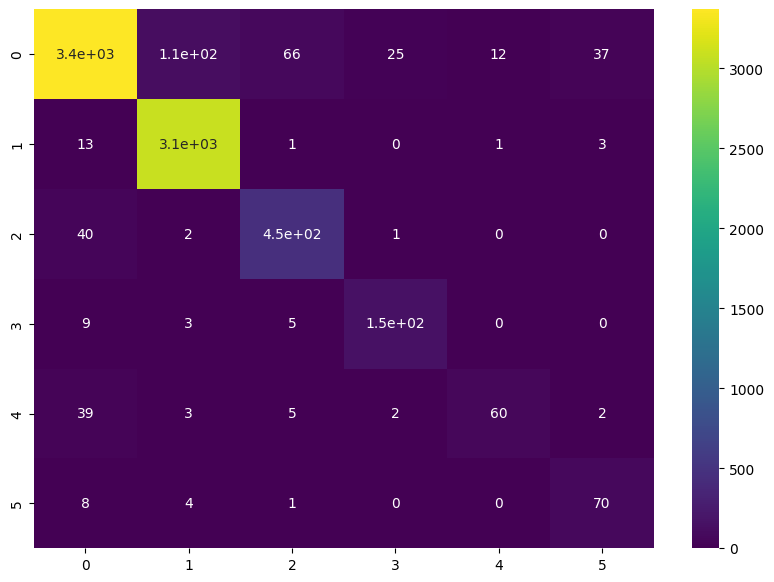

In [ ]:
releaseReport = report(resultBert, x_test, Test_Y)
releaseReport.displayConfusion()

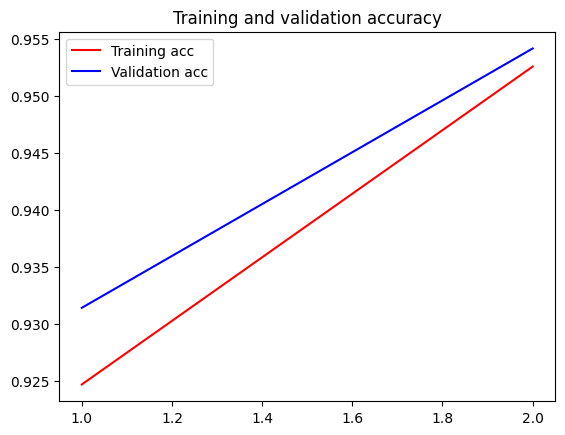

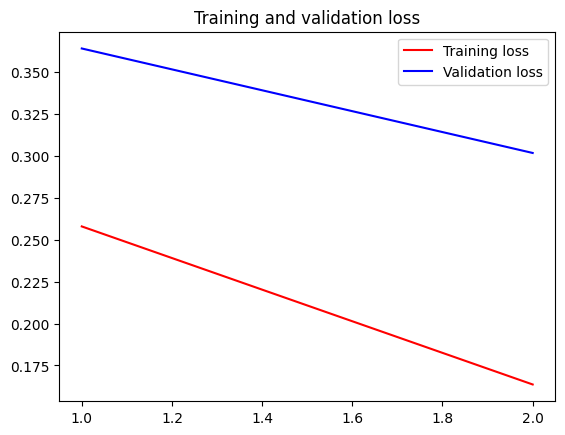

In [ ]:
releaseReport.plotLoss(history)

### save the model to google drive

In [ ]:
resultBert.saveModel('drive/MyDrive/')

### display model summary

In [ ]:
# resultBert.getModel().summary() 

# Double fine tuned for scraped news dataset

## Load scraped news dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

Saving politic_society_business.csv to politic_society_business.csv


## Cleaning text content

In [ ]:
data = importData(file_name)

In [ ]:
data.getData()

,Url,Title,Text,Date,Views,Label
0,https://www.taiwannews.com.tw/en/news/4796805,Taiwan Legislative Speaker You Si-kun arrives ...,"TAIPEI (Taiwan News) — After a 14-hour flight,...",2023/2/1,688.0,Politics
1,https://www.taiwannews.com.tw/en/news/4797037,Taiwan tops Asia in 2022 Human Freedom Index,TAIPEI (Taiwan News) — Taiwan emerged as the f...,2023/2/1,1081.0,Society
2,https://www.taiwannews.com.tw/en/news/4797083,Duck hunt comes to conclusion in southern Taiwan,TAIPEI (Taiwan News) — One would be tempted to...,2023/2/1,2304.0,Society
3,https://www.taiwannews.com.tw/en/news/4797107,Taiwan business leader joins DPP-linked think ...,TAIPEI (Taiwan News) — The chairman of Pegatro...,2023/2/1,622.0,Politics
4,https://www.taiwannews.com.tw/en/news/4797204,DPP Chairman Lai names 3 key tasks for Taiwan’...,TAIPEI (Taiwan News) — In his first address to...,2023/2/1,879.0,Politics
...,...,...,...,...,...,...
822,https://www.taiwannews.com.tw/en/news/4841075,"If China attacks Taiwan, war could start in sp...",TAIPEI (Taiwan News) — In a new CBS broadcast ...,2023/3/20,8922.0,Politics
823,https://www.taiwannews.com.tw/en/news/4841082,"Taiwan, Japan ruling parties to discuss securi...",TAIPEI (Taiwan News) — Taiwan’s Democratic Pro...,2023/3/20,1134.0,Politics
824,https://www.taiwannews.com.tw/en/news/4841167,"Taiwan TikToker rushes court at Dwight Howard,...",TAIPEI (Taiwan News) — A Taiwanese TikToker ru...,2023/3/20,2857.0,Society
825,https://www.taiwannews.com.tw/en/news/4841191,Putin to host ally Xi in Russia as Ukraine war...,Russian President Vladimir Putin hosts Chinese...,2023/3/20,334.0,Politics


In [ ]:
data.text_preprocessing('Text')

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

In [ ]:
new_df = data.getData()
new_df.value_counts("Label")

Label
Politics    438
Society     261
Business    128
dtype: int64

In [ ]:
data.getData().shape

(827, 6)

In [ ]:
dictLabel = {"Politics": 0, "Society": 1, "Business": 2}
data.convertLabel('Label', dictLabel)
Train_X, Val_X, Test_X, Train_Y, Val_Y, Test_Y = data.splitTrain(0.2, 'Text', 'Label')
train_ds = pd.concat([Train_X, Train_Y], axis=1)
val_ds = pd.concat([Val_X, Val_Y], axis=1)
test_ds = pd.concat([Test_X, Test_Y], axis=1)

## BERT double fine tuned model for news classification (scraped dataset)

###load roberta base tokenizer and model then load the model that has already stored in google drive from cnn dataset (the model will be changed to the model that we have already trained)

In [ ]:
# model_name = 'bert-base-uncased'
model_name = 'roberta-base'

tokenizerBert = AutoTokenizer.from_pretrained(model_name)
modelBert = TFAutoModel.from_pretrained(model_name)
resultBert = customBert(tokenizerBert, modelBert)
model_location = 'drive/MyDrive/'
resultBert.load_model_roberta(model_location)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


### define maximum length of token that will be process in one data. this number will affect processing time. in tokenizeProcess we need to input column name of text that will be processed

In [ ]:
max_len = 256
  
x_train = resultBert.tokenizeProcess(train_ds, max_len, 'Text')
x_val = resultBert.tokenizeProcess(val_ds, max_len, 'Text')
x_test = resultBert.tokenizeProcess(test_ds, max_len, 'Text')

### fine tune pre trained model using number of cluster based on label dictionary that is used in cleaning part. then compile the model using specific learning rate value

In [ ]:
resultBert.fineTune(3, max_len)
resultBert.modelCompile(5e-05)

### train the model using number of epoch and batch size

In [ ]:
history = resultBert.fitModel(x_train, x_val, Train_Y, Val_Y, 2, 16)

Epoch 1/2
38/38 [==============================] - 62s 1s/step - loss: 0.7103 - accuracy: 0.7003 - val_loss: 0.5490 - val_accuracy: 0.8060
Epoch 2/2
38/38 [==============================] - 37s 975ms/step - loss: 0.3869 - accuracy: 0.8889 - val_loss: 0.5326 - val_accuracy: 0.8358


### display confusion matrix and plot accuracy and loss for the model

6/6 [==============================] - 6s 508ms/step

Here is the classification report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        88
           1       0.93      0.75      0.83        52
           2       0.80      0.92      0.86        26

    accuracy                           0.90       166
   macro avg       0.88      0.88      0.88       166
weighted avg       0.90      0.90      0.90       166



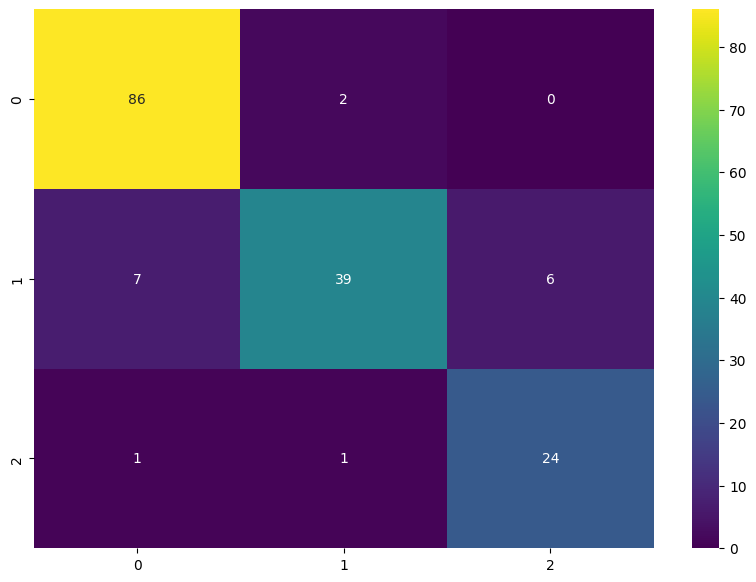

In [ ]:
releaseReport = report(resultBert, x_test, Test_Y)
releaseReport.displayConfusion()

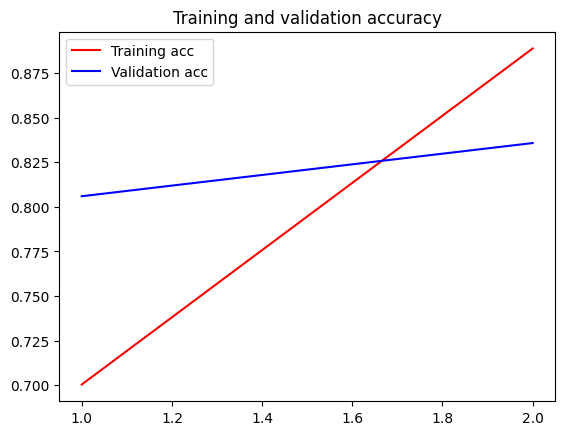

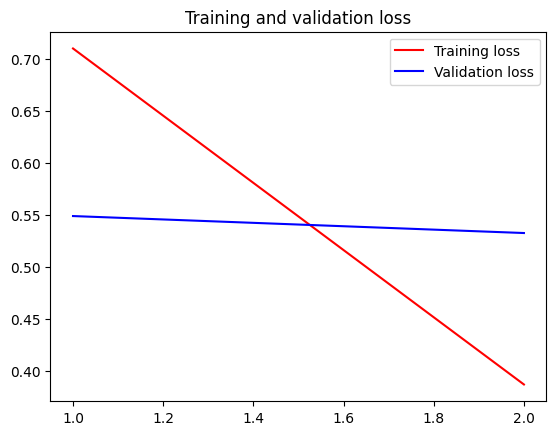

In [ ]:
releaseReport.plotLoss(history)

### save the model to google drive

In [ ]:
# resultBert.saveModel('drive/MyDrive/')

In [ ]:
# resultBert.getModel().summary()